In [ ]:
# !pip install transformers  peft accelerate
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType #parameter efficient fine tuning
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#load data, train test split
dataset = load_dataset('csv', data_files='data.csv')
# 80% train
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#load training example and adjust
# e.g. "openlm-research/open_llama_3b"
model_name = "openlm-research/open_llama_3b" # may be modified later
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    # offload_folder="./off_load",
)

# LoRA fine tuning
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  #based on real modle
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [ ]:
# preprocessing build prompt format
# here prompt is classification
# ====================================
def preprocess_function(example):
    prompt = f"Please classfify the following sentences into three classes (positive, negative and neutral) based on prompt：\n{example['Sentence']}\n class："
    # connect prompt with correct class，format training target（chain-of-thought, extensible if necessary）
    full_text = prompt + example['Sentiment']
    tokenized = tokenizer(full_text, truncation=True, max_length=512)
    return tokenized

In [ ]:
model = get_peft_model(model, lora_config)

# preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=False)
test_dataset = test_dataset.map(preprocess_function, batched=False)

# match length of batch（not MLM module）
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Map:   0%|          | 0/4673 [00:00<?, ? examples/s]

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

In [ ]:

#define training parameter and fine tuning
training_args = TrainingArguments(
    output_dir="./fine_tuned_model",
    per_device_train_batch_size=1,      # adjust based on memory
    gradient_accumulation_steps=4,        # accumulate to meet batch size
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_steps=100,
    evaluation_strategy="no",
    save_total_limit=2,
    push_to_hub=False, # True, create github account and upload all models there
)

trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset,data_collator=data_collator,)

# start fine tuning
trainer.train()

# save the model and tokenizer
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
10,2.656800
20,1.612600
30,1.465700
40,1.358000
50,1.326000
60,1.368200
70,1.369400
80,1.486800
90,1.365000
100,1.189700


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/tokenizer.model',
 './fine_tuned_model/added_tokens.json')

In [ ]:
# classifying prediction based on classifier

def classify_text(text, max_new_tokens=50):
    prompt = f"classfify the following sentences into Positive, Negative and Neutral based on prompt：\n{example['Sentence']}\n class："
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False  #no randomness
        )
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # extract the predicted class from the result, classified first word.
    # predicted = result.split("Class:")[-1].strip().split()[0]
    #turn lower case into higher
    result = result.lower()
    outcome=[result.count("positive"),result.count("negative"),result.count("neutral")]
    predicted = ["positive", "negative", "neutral"][outcome.index(max(outcome))]
    return predicted

In [ ]:
#accuracy
true_labels = []
pred_labels = []

print("start to evalute on training set: \n")
for example in test_dataset:
    true_label = example['Sentiment'].strip()
    pred_label = classify_text(example['Sentence'])
    true_labels.append(true_label)
    pred_labels.append(pred_label)
    print(f"Sentence: {example['Sentence']}")
    print(f"true label: {true_label}, prediction: {pred_label}")
    print("-" * 50)

start to evalute on training set: 

Sentence: Another firm Air Liquide was exempted because it left the market in 1998 .
true label: neutral, prediction: neutral
--------------------------------------------------
Sentence: The oil shale feeder-supply solution will deliver crushed oil shale to the shale oil refinery already in operation as well as to the novel Enefit-280 shale oil technology processing plant .
true label: neutral, prediction: neutral
--------------------------------------------------
Sentence: $SBUX heading for the 200DMA and certain doom if it can not hold there.
true label: negative, prediction: neutral
--------------------------------------------------
Sentence: Strong brand visibility nationally and regionally is of primary importance in home sales , vehicle and consumer advertising .
true label: neutral, prediction: neutral
--------------------------------------------------
Sentence: Talvivaara has secured a 10-year off-take agreement for 100 per cent of its main o

ValueError: At least one label specified must be in y_true

In [ ]:
# Confusion Matrix (make sure label is same as data order)
acc = accuracy_score(true_labels, pred_labels)
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=["positive", "negative", "neutral"])

print("\nFinal Result：")
print("Accuracy: {:.2f}%".format(acc * 100))
print("Confusion Matrix:")
print(conf_matrix)
print("Total number of parameters:", model.num_parameters()/1000000)


Final Result：
Accuracy: 71.34%
Confusion Matrix:
[[255   5 131]
 [ 15  40 123]
 [ 41  20 539]]
Total number of parameters: 3437.1232


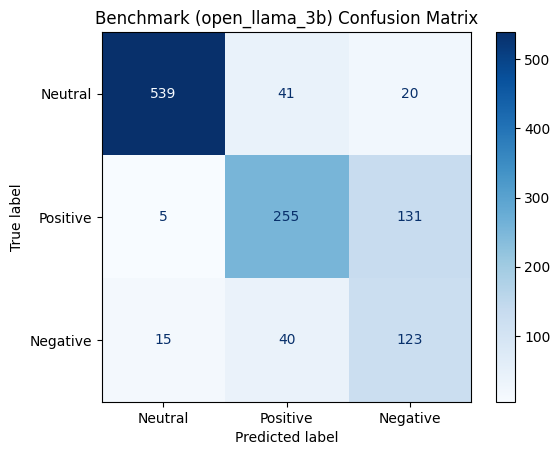

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

final_cm=np.array([[539,41,20],[5,255,131],[15,40,123]])
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=["Neutral","Positive","Negative"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Benchmark (open_llama_3b) Confusion Matrix")
plt.show()